Parametrization of the Track Energy Resolution
==============================================

The energy resolution $P(E_{reco}| E_{true})$ is obtained from the two year diffuse data release (https://icecube.wisc.edu/science/data/HE_NuMu_diffuse).
There, the effective area is provided as function of $E_{true}$, $\cos\theta$ and $E_{reco}$. Summing over $\cos\theta$ and normalizing per $E_{true}$ then gives $P(E_{reco}| E_{true})$.




In [34]:
import h5py
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

In [570]:
# Load Aeff data
with h5py.File("../aeff_input_tracks/effective_area.h5", 'r') as f:
    area10 = f['2010/nu_mu/area'][()]
    tE_bin_edges = f['2010/nu_mu/bin_edges_0'][:] # True Energy [GeV]
    cosz_bin_edges = f['2010/nu_mu/bin_edges_1'][:] # cos(zenith)
    rE_bin_edges = f['2010/nu_mu/bin_edges_2'][:] # Reco Energy [GeV]

Text(0, 0.5, 'Reco Energy [GeV]')

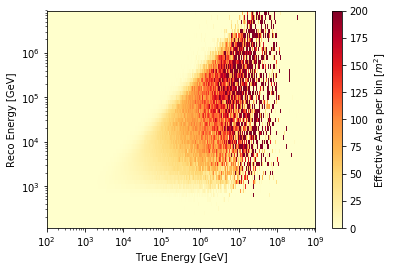

In [589]:
tE_binc = 0.5*(tE_bin_edges[:-1]+lE_bin_edges[1:])
rE_binc = 0.5*(rE_bin_edges[:-1]+rE_bin_edges[1:])

plt.pcolormesh(tE_binc, rE_binc, area10.sum(axis=1).T, vmax=200, cmap=plt.cm.YlOrRd)
cbar = plt.colorbar()
cbar.set_label("Effective Area per bin [$m^2$]")
plt.loglog()
plt.xlabel("True Energy [GeV]")
plt.ylabel("Reco Energy [GeV]")

In [614]:
class Residuals:
    """
    Helper class for calculating residuals of model compared to data
    """
    def __init__(self, data, model):
        """
        
        Parameters:
        -----------
        data: tuple
            data x- and y coordinates
            
        model: callable
            A callable encoding the model. The callable should take
            `x` as first argument and a parameter list as second argument.
        """
        self.data_x, self.data_y = data
        self.model = model
        
    def __call__(self, params):
        """
        Return the residuals w.r.t to model(params)
        """
        expec = self.model(self.data_x, params)
        #chi2 =  (expec-self.data_y)**2/expec
       
        residuals = expec-self.data_y
        return residuals


Fitting
-------

Fit a lognormal distribution to $P(E_{reco} | E_{true})$ using least squares

In [638]:
logrEbins = np.log10(rE_binc)
fit_params = []
rebin = 3 # Rebin to have higher statistics at upper and lower end of energy range
rebinned_binc = np.zeros(int(len(tE_binc)/rebin))
model = lambda x, pars: stats.lognorm.pdf(x, scale=pars[0], s=pars[1]**2)

# Fitting loop
for index in range(int(len(tE_binc)/rebin)):
    #Calculate rebinned bin-centers as mean of first and last bin being summed
    rebinned_binc[index] = 0.5*(tE_binc[[index*rebin, rebin*(index+1)-1]]).sum()
    
    #Calculate the energy resolution for this true-energy bin
    e_reso = area10.sum(axis=1)[index*rebin:(index+1)*rebin].sum(axis=0)
    if e_reso.sum() > 0:
        #Normalize to prob. density / bin
        e_reso = e_reso/e_reso.sum() / (logrEbins[1]-logrEbins[0])

        residuals = Residuals((logrEbins, e_reso), model)
        
        #Calculate seed as mean of the resolution to help minimizer
        seed_mu = np.average(logrEbins, weights=e_reso)
        if ~np.isfinite(seed_mu):
            seed_mu = 3

        res = scipy.optimize.least_squares(
            residuals,
            [seed_mu, 0.3],
            bounds=((np.max([0, seed_mu-0.5]), 0.2), ((seed_mu+0.5, np.inf))))
        fit_params.append(res.x)
    else:
        fit_params.append([0, 0])
fit_params = np.asarray(fit_params)


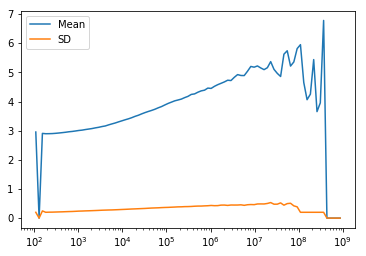

In [640]:
# Plot the fit parameters
plt.plot(rebinned_binc, fit_params[:, 0], label="Mean")
plt.plot(rebinned_binc, fit_params[:, 1], label="SD")
plt.semilogx()
plt.legend()

Parametrization of lognormal parameters as function of $log_{10}(E_{true})$ using polynomial
----------------------------------------------------------------------------------

In [643]:
#Min and max values
imin = 5
imax = -15

#Degree of polynomial 
polydeg = 5

params_mu = np.polyfit(np.log10(rebinned_binc)[imin:imax], fit_params[:, 0][imin:imax], polydeg)
params_sigma = np.polyfit(np.log10(rebinned_binc)[imin:imax], fit_params[:, 1][imin:imax], polydeg)

Text(0, 0.5, 'SD')

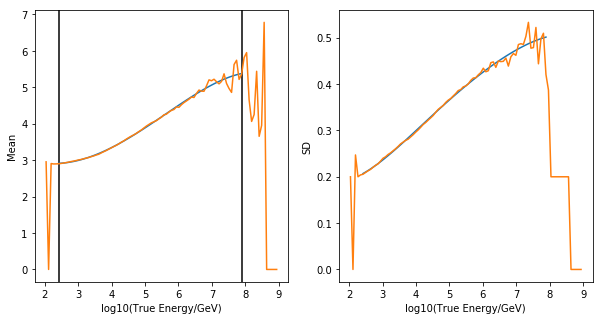

In [648]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].axvline(np.log10(rebinned_binc[imin]), color="k")
axs[0].axvline(np.log10(rebinned_binc[imax]), color="k")
xs = np.linspace(*np.log10(rebinned_binc[[imin, imax]]), num=100)

axs[0].plot(xs, np.poly1d(params_mu)(xs))
axs[0].plot(np.log10(rebinned_binc), fit_params[:, 0], label="Mean")

axs[0].set_xlabel("log10(True Energy/GeV)")
axs[0].set_ylabel("Mean")
axs[1].plot(xs, np.poly1d(params_sigma)(xs))
axs[1].plot(np.log10(rebinned_binc), fit_params[:, 1], label="SD")
axs[1].set_xlabel("log10(True Energy/GeV)")
axs[1].set_ylabel("SD")

Check Parametrizations
-----------------------

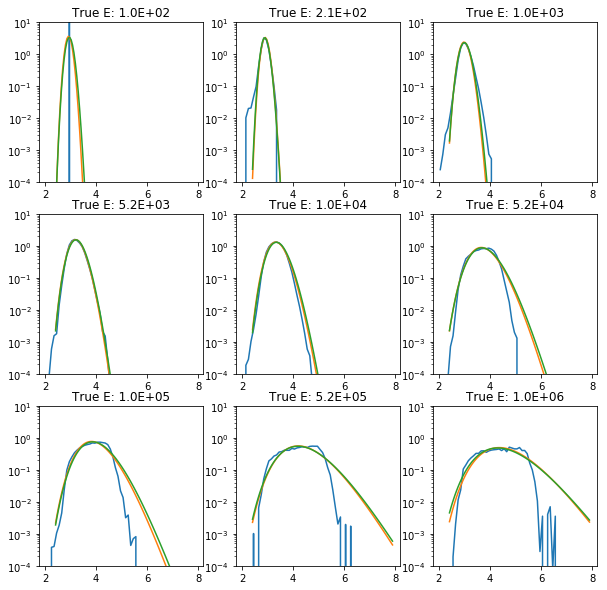

In [649]:
plot_energies = [100, 200, 1E3, 5E3, 1E4, 5E4, 1E5, 5E5, 1E6] # GeV 

#Find true energy bins for the chosen plotting energies
plot_indices = np.digitize(plot_energies, tE_binc)

#Parameters are relative to the rebinned histogram
param_indices = np.digitize(plot_energies, rebinned_binc)

mu_poly = np.poly1d(params_mu)
sigma_poly = np.poly1d(params_sigma)

fig, axs = plt.subplots(3, 3, figsize=(10, 10))

fl_ax = axs.ravel()
for i, pi in enumerate(plot_indices):
    e_reso = area10.sum(axis=1)[int(pi/rebin)*rebin:(int(pi/rebin)+1)*rebin].sum(axis=0)
    e_reso = e_reso/e_reso.sum() / (logrEbins[1]-logrEbins[0])
    fl_ax[i].plot(logrEbins, e_reso)
    
    mu = mu_poly(np.log10(plot_energies[i]))
    sigma = sigma_poly(np.log10(plot_energies[i]))
    res = fit_params[param_indices[i]]

    fl_ax[i].plot(xs, scipy.stats.lognorm.pdf(xs, scale=mu, s=sigma**2))
    fl_ax[i].plot(xs, scipy.stats.lognorm.pdf(xs, scale=res[0], s=res[1]**2))
    fl_ax[i].set_ylim(1E-4, 10)
    fl_ax[i].set_yscale("log")
    fl_ax[i].set_title("True E: {:.1E}".format(tE_binc[pi]))

